# Model performance evaluation and visualization
Authors: Katrin Wernicke, code adapted from Alexey Bogatyrev

This notebook was especially written for the internship presentation given on 31st of March 2022 at the University of Tuebingen. \
This notebook doesn't contain any essential information or code. 

This notebook uses a sample of the SpaceNet dataset, which wasn't shown to the model yet, to test the perfomance of the model with different training configurations. \
The accuracy metric F1-score is calculated.\
Also, an example of a predicted mask is visualized. 


# Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
import tensorboard
import glob
import os
import re
import numpy as np
import pandas as pd
from sklearn.metrics import multilabel_confusion_matrix
import time
from matplotlib import pyplot as plt
from matplotlib.collections import PolyCollection

# Data Generators

generate a test dataset of SpaceNet data which was not used for training the model. 


In [ ]:
# Define global variables
DIRECTORY = 'H:/DL_BuildingDetection/1_TrainingData/tiles'

<font size='1'>It looks like models with higher number of filters per class in the final layer are less prone to overfit and perform better.<br>
Let's now explore how model's perfomance depends on the number of filters per class.</font>

In [5]:
#Load model
model = keras.models.load_model("H:/DL_BuildingDetection/1_ModelEngineering/models/0_model")

In [ ]:
# gather all files 
files = glob.glob(os.path.join(DIRECTORY,'*'))

# create a list of all images in the directory
pattern_img = '.*\.jpg'
files_img = list(filter(re.compile(pattern_img).match,files))

# create a list of all labeled images / building masks
pattern_mask = '.*\.tif'
files_mask = list(filter(re.compile(pattern_mask).match,files))

files_mask = sorted(files_mask)
files_img = sorted(files_img)

print(' All files: {}\n'.format(len(files)),
      'Image files: {}\n'.format(len(files_img)),
      'Mask files: {}'.format(len(files_mask)))

In [ ]:
# create a dataframe of the satellite images and their respective mask 
df_files = pd.DataFrame(columns=['img','mask'])
df_files['img'] = files_img
df_files['mask'] = files_mask

# return a random sample [frac defines how big of a fraction of the original data the sampled data should be; 1 means equal]
df_files = df_files.sample(frac=1,random_state=10)

train_bound = int(len(df_files) * 0.7)
val_bound = int(len(df_files) * 0.85)

# define 70% of the data as trainings data and 15% for validation and 15% for testing
df_train = df_files.iloc[:train_bound]
df_val = df_files.iloc[train_bound:val_bound]
df_test = df_files.iloc[val_bound:]

print(' Train examples: {}\n'.format(len(df_train)),
      'Validation examples: {}\n'.format(len(df_val)),
      'Test examples: {}\n'.format(len(df_test)))

In [6]:
def make_test_gen(df_test,target_size,batch_size,seed):
    test_gen = keras.preprocessing.image.ImageDataGenerator()
    test_generator = test_gen.flow_from_dataframe(
        dataframe=df_test,        
        x_col='img',
        target_size=target_size,
        batch_size=batch_size,
        seed = seed,
        class_mode=None,
        color_mode='rgb',
        shuffle=False)
    return test_generator



def mask_gen(df_test,target_size,batch_size,seed):
  mask_gen = keras.preprocessing.image.ImageDataGenerator()

  mask_generator = mask_gen.flow_from_dataframe(
          dataframe=df_test,        
          x_col='mask',
          target_size=target_size,
          batch_size=batch_size,
          seed = seed,
          class_mode=None,
          color_mode='grayscale')
  return mask_generator

def make_mask_gen(df_test,target_size = (256, 256),batch_size = 1, seed = 0):
  
  mask_gen_ =  mask_gen(df_test,target_size,batch_size,seed) # tuple_gen consists of two generators

  def _gen():  # loop through tuple_gen and for the mask layers: assign values [1,2] to y= [100,255]
    while True: 
      y = next(mask_gen_) # returns the next item in a generator, x = img_generator, y = mask_generator
      
      y[y==100] = 1
      y[y==255] = 2

      yield y

  return _gen()
    

### Prediction on test dataset

In [7]:
test_image_gen = make_test_gen(df_test, batch_size = 1,target_size = (256, 256), seed = 0) #seed = 0 to keep the sequence
img_test = next(test_image_gen,0)

Found 578 validated image filenames.


In [8]:
test_mask_gen = make_mask_gen(df_test, batch_size = 1,target_size = (256, 256), seed = 0)
mask = next(test_mask_gen)
type(mask)

Found 578 validated image filenames.


numpy.ndarray

In [10]:
# Generate output predictions for the input samples
mask_predicted = model.predict(test_image_gen, verbose = 1)

578/578 [==============================] - 76s 131ms/step


#### Calculate F1 score as Accuracy metrics for predicted masks

In [ ]:
msk = next(test_mask_gen, 578)
msk_ = np.squeeze(msk)
cfm_ = multilabel_confusion_matrix(msk_.flatten(),mask_pred_rend.flatten())

In [ ]:
import warnings
warnings.filterwarnings("ignore")
f1_class1 = []
f1_class2 = []
f1_class3 = []
for n in range(len(mask_predicted)): 
    mask = next(test_mask_gen, n)
    mask = np.squeeze(mask)
    mask_pred = mask_predicted[n]
    mask_pred_rend = np.argmax(mask_pred,axis=-1)
    cfm = multilabel_confusion_matrix(mask.flatten(),mask_pred_rend.flatten())
    for i in range(3):
        prec = cfm[i,1,1]/(cfm[i,1,1]+cfm[i,0,1]) 
        recall= cfm[i,1,1]/(cfm[i,1,1]+cfm[i,1,0])
        f1  = 2*prec*recall/(prec+recall)
        if i == 0: 
            f1_class1.append(f1)
        elif i == 1: 
            f1_class2.append(f1)
        elif i == 2: 
            f1_class3.append(f1)

In [36]:
def Average(lst):
    return np.nanmean(lst)

f1_class1_average = Average(f1_class1)
f1_class2_average = Average(f1_class2)
f1_class3_average = Average(f1_class3)

print("f1_class1_average: ", f1_class1_average, 
      "f1_class2_average:", f1_class2_average, 
      "f1_class3_average:", f1_class3_average)


f1_class1_average:  0.7831616423652268 f1_class2_average: 0.144423577437097 f1_class3_average: 0.05893167385432384


### Visualizing prediction results
These resulting plots were used for the PowerPoint Presentation

In [37]:
test_gen = make_gen4unet(df_test, batch_size = 1,target_size = (256, 256), seed = 0) #seed 0 to keep the Reihenfolge
img_test, mask_test = next(test_gen, 5)

Found 578 validated image filenames.
Found 578 validated image filenames.


In [38]:
# Generate output predictions for the input samples
mask_predicted = model.predict(img_test, verbose = 1)

1/1 [==============================] - 0s 479ms/step


In [39]:
# define function to display the results
def predict_buildings(img,mask, mask_pred):
    i=0
    img=img[i].astype(int)
    mask = mask[i]
    mask_pred=np.squeeze(mask_pred[i])
    mask_pred_rend=np.argmax(mask_pred, axis=-1)
    plt.figure(figsize=0.8*np.array([3*6.4, 4.8]))
    #fig, ax = plt.subplots(2,2)
    plt.subplot(141).set_title("Image")
    # = plt.subplot(1,3,1), 1 row, 4 columns,  first subplot (from right to left, first top row)
    plt.imshow(img)
    plt.subplot(142).set_title("Label")
    plt.imshow(mask)
    plt.subplot(143).set_title("predicted mask")
    plt.imshow(mask_pred)
    plt.subplot(144).set_title("max-rend predicted mask")
    plt.imshow(mask_pred_rend)
    plt.show()
    
    return mask_pred, mask_pred_rend

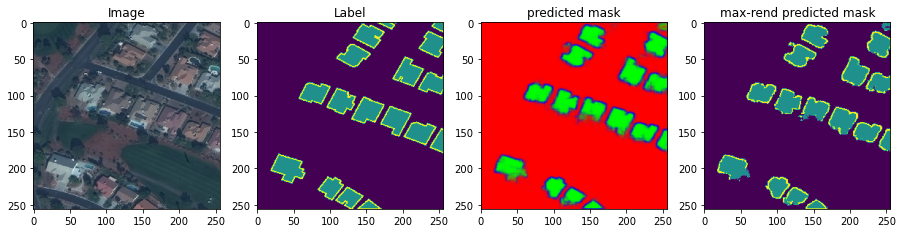

In [40]:
mask_pred_, mask_pred_rend_ = predict_buildings(img_test, mask_test, mask_predicted)